# Visualize attention

This notebook: TODO add description

In [1]:
import sys
import os

# Get the absolute path of the parent directory.
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Add the parent directory to the system path to be able to import modules from 'lib.'
sys.path.append(parent_dir)

In [2]:
%%capture

from bertviz import model_view, head_view
import datasets

import ipywidgets as widgets
from IPython.display import HTML, Markdown as md
import itertools

from lib.memory import DSDM
from lib.utils import cleanup, configs, inference, learning, preprocess, utils 

import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from nltk.corpus import stopwords
import numpy as np
import random

import pandas as pd
import pathlib

import string
import seaborn as sns

from transformers import AutoTokenizer, AutoModel

import torch
import torchhd as thd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F 

from tqdm import tqdm

### Package options ###
torch.set_printoptions(threshold=10_000)

In [3]:
### Utils ###
def plot_heatmap(
    x: np.array,
    labels: np.array,
    filename:str,
    figsize: int=15,
    save: bool=False
) -> None:
    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(
        x,
        linewidth=0.5,
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
        fmt='.2f',
    )
    plt.title(f'Layer {layer}, Head {head}', fontsize=15)
    
    if save:
        if not os.path.exists('figs'):
            os.makedirs('figs')
        plt.savefig(f'figs/{filename}_layer-{layer}_head-{head}.png', bbox_inches='tight')
    plt.show()
    return

def average_out_and_remove_rows(t: torch.tensor, averages_idx, remove_idx):
    for average_idx in averages_idx:  # The nested lists can have different dimensions.
        # Replace the attention scores of the first token with the average of the token attention scores.
        t[min(average_idx)] = torch.mean(t[average_idx], dim=0, keepdim=True)
    return t[~remove_idx]


def preprocess_attention_scores(attention_scores, averages_idx, remove_idx):
    attention_scores = average_out_and_remove_rows(attention_scores, averages_idx, remove_idx)
    attention_scores = attention_scores.transpose(0, 1)
    attention_scores = average_out_and_remove_rows(attention_scores, averages_idx, remove_idx)
    return attention_scores.transpose(0, 1)

In [4]:
# Load Wikipedia dataset.
# TODO: Split between server and local.
#wiki_dataset = datasets.load_dataset("wikipedia", "20220301.en")['train']
wiki_dataset = datasets.load_dataset(
    "wikipedia",
    "20220301.en",
    cache_dir="/nfs/data/projects/daniela")['train']

Found cached dataset wikipedia (/nfs/data/projects/daniela/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)
Found cached dataset wikipedia (/nfs/data/projects/daniela/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Set seed.
utils.fix_seed(41)

Using seed: 41

Using seed: 41

In [6]:
# Construct train set (texts) and inference set (sentences; in and out of train set text).
train_size = 100
test_size = 100

# Text indeces.
train_idx = np.random.randint(0, len(wiki_dataset), size=train_size)
#train_idx = np.append(np.append(np.append(train_idx[0], train_idx[0]), train_idx[0]), train_idx[0]) 

# Text indeces from which we extract sentences.
intest_idx = np.random.choice(train_idx, test_size)
outtest_idx = np.random.choice(np.setdiff1d(np.arange(len(wiki_dataset)), train_idx), test_size)

In [7]:
inference_sentences_in = []
inference_sentences_out = []

for idx_in, idx_out in zip(intest_idx, outtest_idx):
    # Get sentences.
    sentences_in = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_in)]['text'])
    sentences_out = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_out)]['text'])
    
    # Get sentence index.
    sentence_idx_in = np.random.randint(0, len(sentences_in), size=1).item()
    sentence_idx_out = np.random.randint(0, len(sentences_out), size=1).item()

    # Append sentence to list.
    inference_sentences_in.append(sentences_in[sentence_idx_in])
    inference_sentences_out.append(sentences_out[sentence_idx_out])

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

MAXIMUM_SEQUENCE_LENGTH = 512

In [9]:
# Attention weight threshold
as_threshold = 0.0

In [10]:
sentences = [
    'The National Gallery is in London.',
    'The Pink Gallery is in London.',
    'She won the Pulitzer Prize for Fiction.',
    'She won the David Moore Award for Music.',
    'John joined Alice in Chains onstage.',
    'John joined The Rolling Stones onstage.',
    'John joined The Happy Cowboys onstage.',
    'The blue mansion is also big.',
    "Let's call it a day.",
    'It takes two to tango.',
    'The Firenze group has lost.'
]

In [11]:
labels_list = []
attention_matrix_list = []

for text in sentences:
    # Get tokens
    encoding = tokenizer.encode(text)
    labels = tokenizer.convert_ids_to_tokens(encoding)
    labels_list.append(labels)
    
    # Get attention matrices.
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)
    attention_matrix = outputs.attentions
    attention_matrix_list.append(attention_matrix)

## Raw attention

In [13]:
save = True
show = True

In [14]:
layer = 0

In [15]:
annot = True

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipykernel_1572262/2836067105.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])
/tmp/ipykernel_1572262/2836067105.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


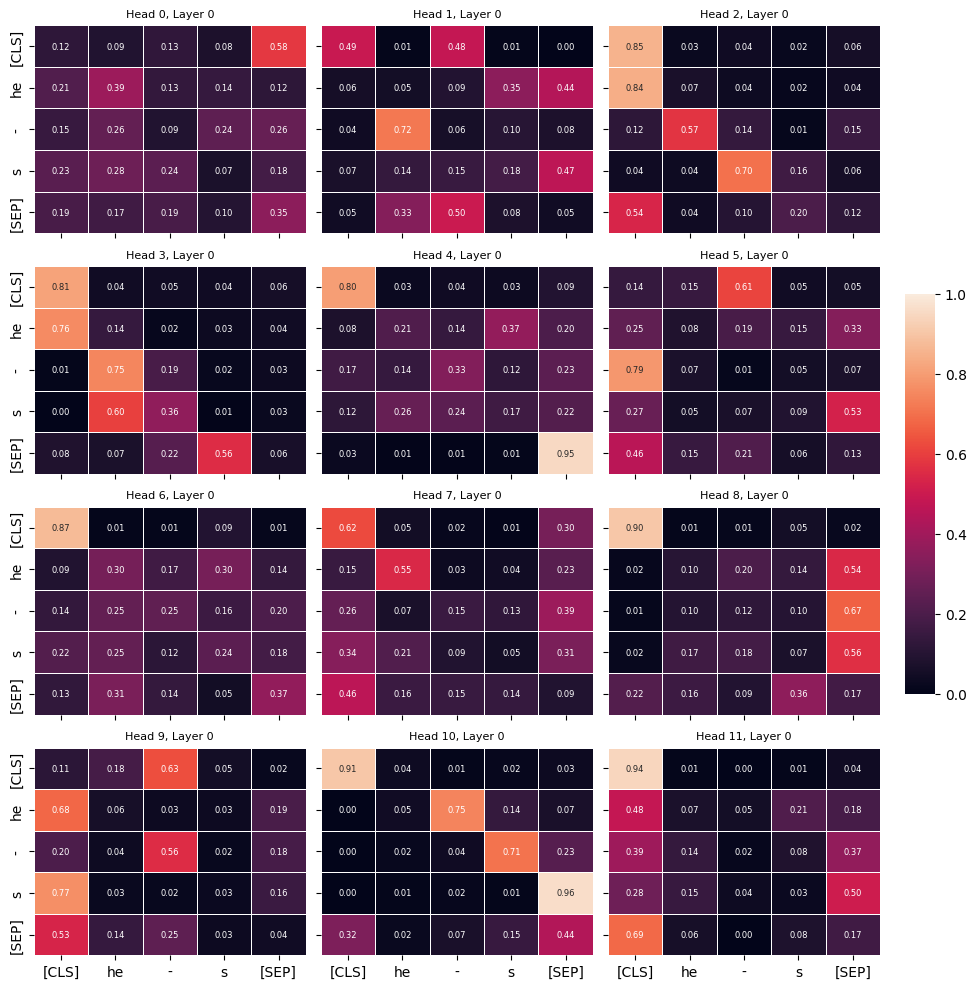

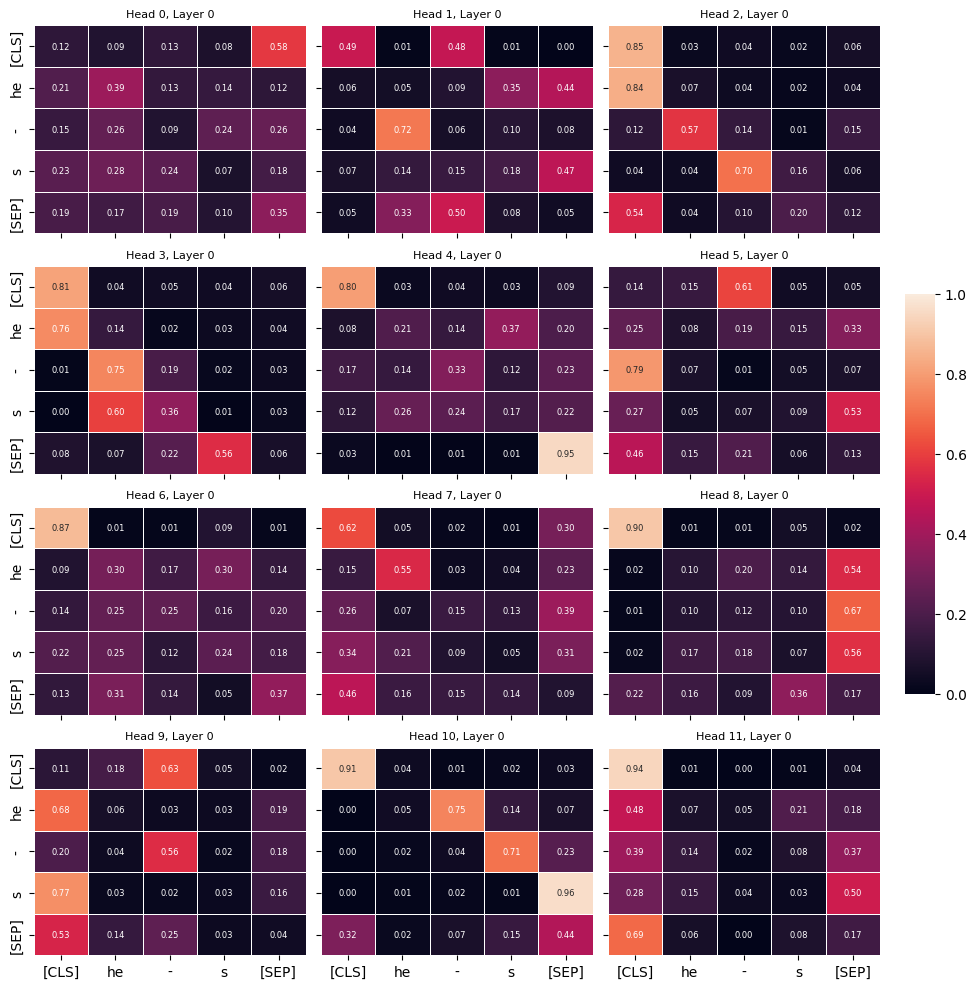

In [16]:
for sentence_idx in range(len(sentences)):
    fig, axn = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 10))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    # Visualize all attenntions
    model_view(attention_matrix_list[sentence_idx], labels_list[sentence_idx])
    
    # Visualize attention matrices of layer
    for head, ax in enumerate(axn.flat):
        head_scores_raw_tensor = attention_matrix_list[sentence_idx][layer][0][head].detach().clone()

        head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()

        head_scores = head_scores_raw

        #plot_heatmap(head_scores, labels, filename='s1', figsize=15, save=True)
        
        sns.heatmap(
            head_scores,
            vmin=0,
            vmax=1,
            xticklabels=labels_list[sentence_idx],
            yticklabels=labels_list[sentence_idx],
            ax=ax,
            annot=annot,
            linewidth=0.5,
            fmt='.2f',
            cbar=head == 0,
            cbar_ax=None if head else cbar_ax,
            annot_kws={"size": 6},
        )
        ax.set_title(f'Head {head}, Layer {layer}', fontsize=8)

    fig.tight_layout(rect=[0, 0, .9, 1])
    if save:
        if not os.path.exists('figs'):
            os.makedirs('figs')
        plt.savefig(f'figs/s{sentence_idx}_attention.png', bbox_inches='tight')
    if show:
        plt.show()

In [17]:
head_view(attention_matrix, labels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
model_view(attention_matrix_list[3], labels_list[2])

IndexError: list index out of range

IndexError: list index out of range

## Processed attention

In [ ]:
i = 0
averages_idx = []
while i < len(labels) - 1:
    j = i + 1
    average_idx = []
    while labels[j].startswith('#'):
        average_idx.append(j)
        labels[i] += labels[j].replace('#', '')
        j += 1
    if average_idx != []:
        average_idx.append(i)
        averages_idx.append(average_idx)
    i = j

hashtag_idx = np.array([label.startswith("#") for label in labels])
stopwords_idx = np.array([label in stopwords.words('english') for label in labels])
punctuation_idx = np.array([label in string.punctuation for label in labels])
#other_idx = 
remove_idx = hashtag_idx | punctuation_idx | stopwords_idx
labels = np.array(labels)[~remove_idx]
labels = labels[1:(len(labels) - 1)]
#print(labels)

In [ ]:
layer = 0

for head in range(12):
    head_scores_raw_tensor = attention_matrix[layer][0][head].detach().clone()
    
    head_scores_raw_tensor = preprocess_attention_scores(
        head_scores_raw_tensor, averages_idx, remove_idx
    )
        
    head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()
    
    head_scores = head_scores_raw[1:(len(head_scores_raw) - 1), 1:(len(head_scores_raw) - 1)].copy()

    head_scores[head_scores < as_threshold] = 0
    plot_heatmap(head_scores, labels)

In [ ]:
# text = "Firenze firenze"
# encoding = tokenizer.encode(text)
# labels = tokenizer.convert_ids_to_tokens(encoding)

In [ ]:
# i = 0
# averages_idx = []
# while i < len(labels) - 1:
#     j = i + 1
#     average_idx = []
#     while labels[j].startswith('#'):
#         average_idx.append(j)
#         labels[i] += labels[j].replace('#', '')
#         j += 1
#     if average_idx != []:
#         average_idx.append(i)
#         averages_idx.append(average_idx)
#     i = j

# hashtag_idx = np.array([label.startswith("#") for label in labels])
# labels = np.array(labels)[~hashtag_idx]

In [ ]:
# Torch implementation.

# t = torch.tensor(head_scores_raw)
# i = torch.tensor(averages_idx)

# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)
# t = torch.transpose(t, 0, 1)
# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)

# t = torch.transpose(t, 0, 1)